In [1]:
#| echo: false

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
# Config plt.
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')
rcParams['figure.figsize'] = 8, 5

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

from plotnine import *

##ML

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_val_score
from sklearn.inspection import partial_dependence

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#| echo: false

df = pd.read_excel('../data/Data_Train.xlsx')

# Flights Price Machine Learning
## Description
Flight tickets price prediction using different machine learning models such as K-nearest neighbor, decision tree & linear model.

## Data

The dataset contains flight tickets price from different airline companies along with other features such as the flight destination, and duration.


| Feature        |  Description                                       |
|   :---:        |     :---:                                          |
| Price(target)  | The price of the ticket.                           |
| Airline        | The airline name.                                  |
| Source         | The source from which the service begins.          |
| Destination    | The destination where the service ends.            |
| Dep_Time       | The time when the journey starts from the source.  |
| Arrival_Time   | The arrival time at the destination.               |
| Duration       | The total flight duration.                         |
| Total_Stops    | The total stops between the source and destination.|
| Additional_Info| Any additional information about the flight.       |
|Date_of_Journey | The date of the journey.                           |
|Route           | The route taken by the flight to reach the destination.|

<br>

| Number of Entries |  Number of Features  |
|   :---:           |     :---:            |
|   10683           |           11         |


### Data Cleaning

- Extracted Year, Month, Day form "Date_of_Juourney"
- Dropped "year" since its value is the same for all entires
- Dropped "date_of_journey"
- Converted "Duration" to seconds
- Modified "additional_info" value "No Info" to "No info"
- Dropped messing values
- Dropped duplicated entries (kept one)
- Converted "total_stops" from string to numeric
- Categorize "dep_time"and "arrival_time" (i.e. "mid_night", "moring", "afternoon", "evening")
- Dropped "route" since we will be using "total_stops"

In [3]:
#| echo: false

# Modify feature names to be lower cased.
df.columns = df.columns.str.lower()

# Change "data_of_journey" type to datetime.
df.date_of_journey = pd.to_datetime(df.date_of_journey, infer_datetime_format=True)

# Create "year", "month", and "day" features.
df['year'] = pd.DatetimeIndex(df.date_of_journey).year
df['month'] = pd.DatetimeIndex(df.date_of_journey).month
df['day'] = pd.DatetimeIndex(df.date_of_journey).day

# Convert "duration to seconds"
df.duration = df.duration.apply(lambda x: f'{x} 0m' if not 'm' in x else x)
df.duration = df.duration.apply(lambda x: f'0h {x}' if not 'h' in x else x)
df.duration = df.duration.apply(lambda x: int(x.split()[0][:-1])*3600 + int(x.split()[1][:-1])*60)

# Drop "year" since its value is the same for all entires.
df.drop(columns=['year'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Modify "additional_info" value "No Infor" to "No info"
df.additional_info = df.additional_info.str.replace('No Info', 'No info')

# Drop Null values.
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop douplicated entires.
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Modify "total_stops" values to contain only the number.
df.total_stops = df.total_stops.apply(lambda x: int(x.split()[0]) if not 'non-stop' in x.split()[0] else 0)

# Categorize "dep_time"and "arrival_time".
def categorizee_time(input):
    time = input.split()[0]
    if int(time[:2]) >= 0 and int(time[:2]) < 6:
        return 'mid_night'
    elif int(time[:2]) >= 6 and int(time[:2]) < 12:
        return 'morning'
    elif int(time[:2]) >= 12 and int(time[:2]) < 18:
        return 'afternoon'
    elif int(time[:2]) >= 18 and int(time[:2]) < 24:
        return 'evening'

df.dep_time = df.dep_time.apply(categorizee_time)
df.arrival_time = df.arrival_time.apply(categorizee_time)

# Drop "date_of_journey" and "route".
df.drop(columns=['date_of_journey', 'route'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
#| echo: false

# Show a smaple of the cleaned dataset.
df.sample(2)

,airline,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,month,day
9990,IndiGo,Delhi,Cochin,mid_night,evening,57900,1,No info,6758,5,18
1231,Jet Airways,Kolkata,Banglore,afternoon,evening,98400,1,In-flight meal not included,7064,4,1


### EDA

#### Statistical Summarization

In [5]:
#| echo: false

# Display stats summary of numeric values.
df.describe()

,duration,total_stops,price,month,day
count,10462.000000,10462.000000,10462.000000,10462.000000,10462.000000
mean,37786.895431,0.802332,9026.790289,4.701491,13.463200
std,30041.942724,0.660609,4624.849541,1.163802,8.467493
min,300.000000,0.000000,1759.000000,3.000000,1.000000
25%,10200.000000,0.000000,5224.000000,3.000000,6.000000
50%,30300.000000,1.000000,8266.000000,5.000000,12.000000
75%,54600.000000,1.000000,12344.750000,6.000000,21.000000
max,171600.000000,4.000000,79512.000000,6.000000,27.000000


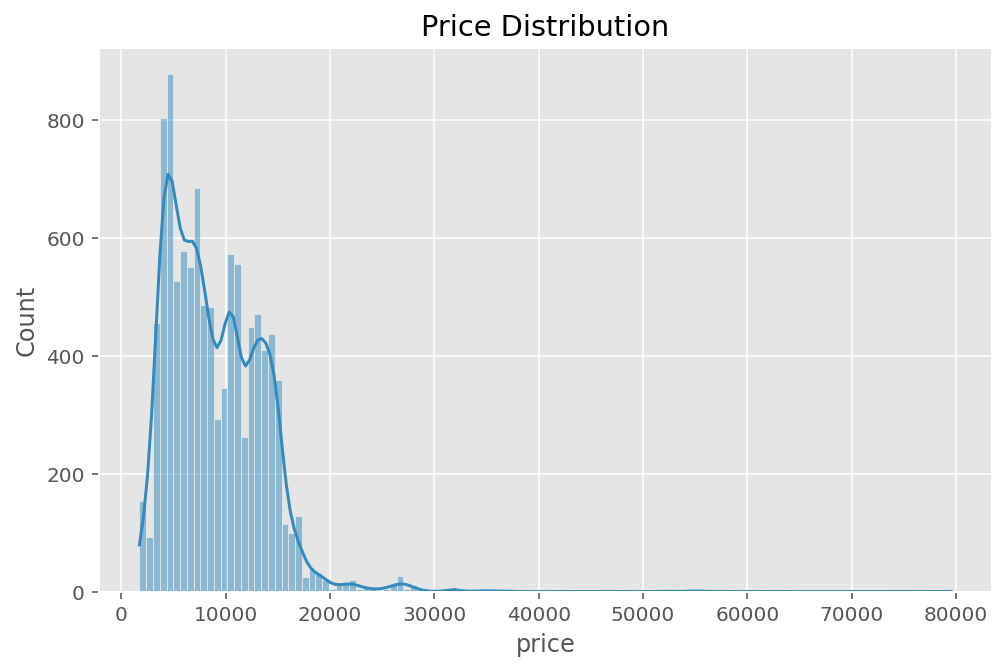

In [6]:
#| echo: false

# Plot a box plot of "price".
sns.histplot(df.price, kde=True)
plt.title('Price Distribution');
#insight: price distribution is positively-skewed.

Insight: Price distribution is positively-skewed.

In [7]:
#| echo: false

# Display the correlation between the different features.
df.corr().style.background_gradient()


,duration,total_stops,price,month,day
duration,1.000000,0.727982,0.501758,0.004874,-0.029810
total_stops,0.727982,1.000000,0.602013,0.039003,-0.018937
price,0.501758,0.602013,1.000000,-0.113396,-0.159044
month,0.004874,0.039003,-0.113396,1.000000,-0.038331
day,-0.029810,-0.018937,-0.159044,-0.038331,1.000000


Insight: Price is highly correlated with total stops and moderately correlated with duration.

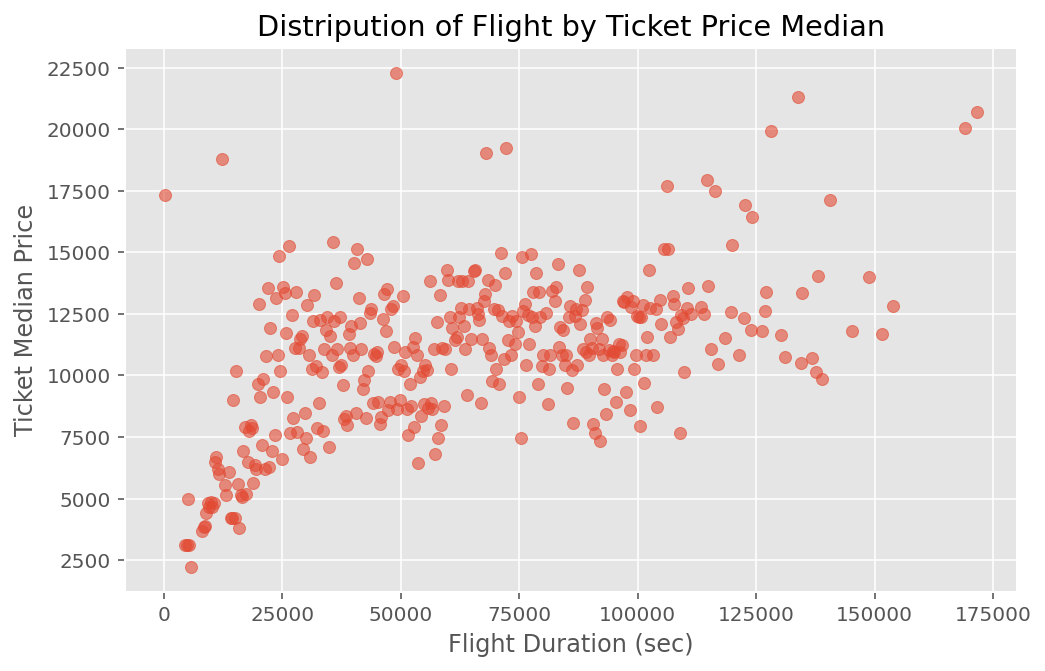

In [8]:
#| echo: false

# Group by duration, and used median of price
# Note: median was chosen because price distribution is positively-skewed.
avg_price_per_duration = df.groupby(['duration'], as_index=False).median()

#Plot a scatter plot of "price" with respect to "duration".
plt.scatter(x=avg_price_per_duration.duration, y=avg_price_per_duration.price, alpha=0.6)
plt.xlabel('Flight Duration (sec)')
plt.ylabel('Ticket Median Price')
plt.title('Distripution of Flight by Ticket Price Median');

Insight: As the durations increase, the median price increases.

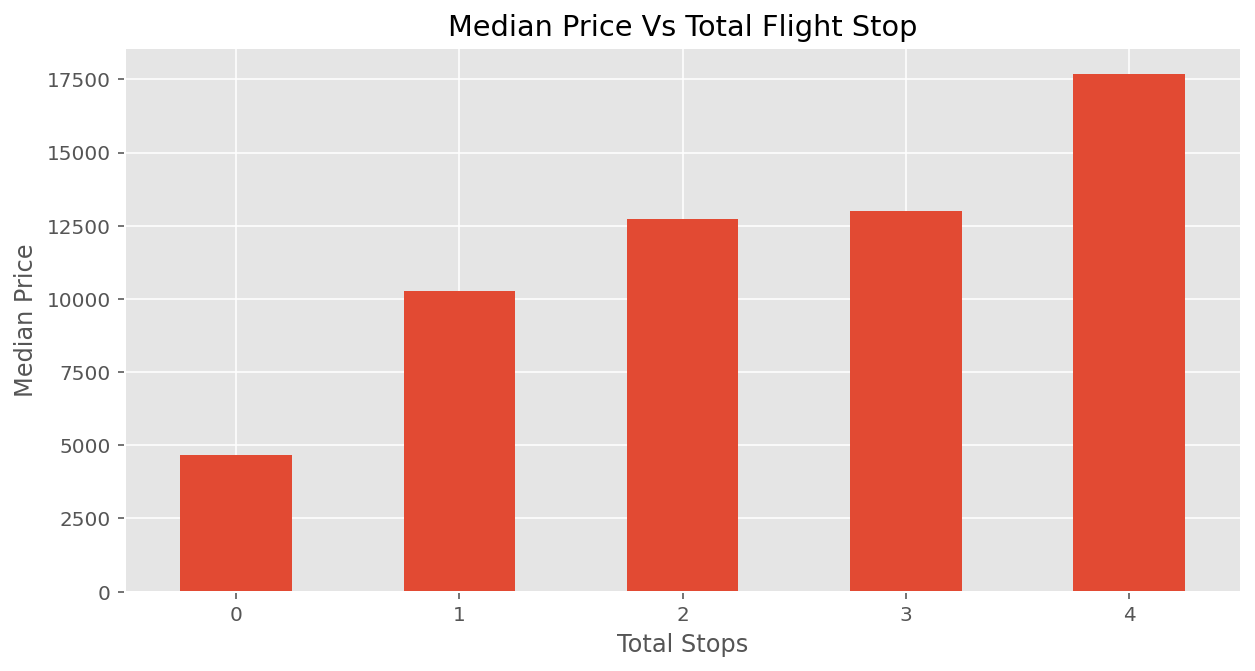

In [9]:
#| echo: false

fig = plt.figure(figsize=(10,5))
median_stops_price = df.groupby('total_stops')['price'].median()
median_stops_price.plot.bar(x = 'total_stops', rot=360)
#df.sort_values('airline',inplace=True) << I WANT TO ARRANGE IT IN DESCENDING
plt.title("Median Price Vs Total Flight Stop")
plt.xlabel("Total Stops")
plt.ylabel("Median Price");

Insight: Median price increase as the total stops increase.

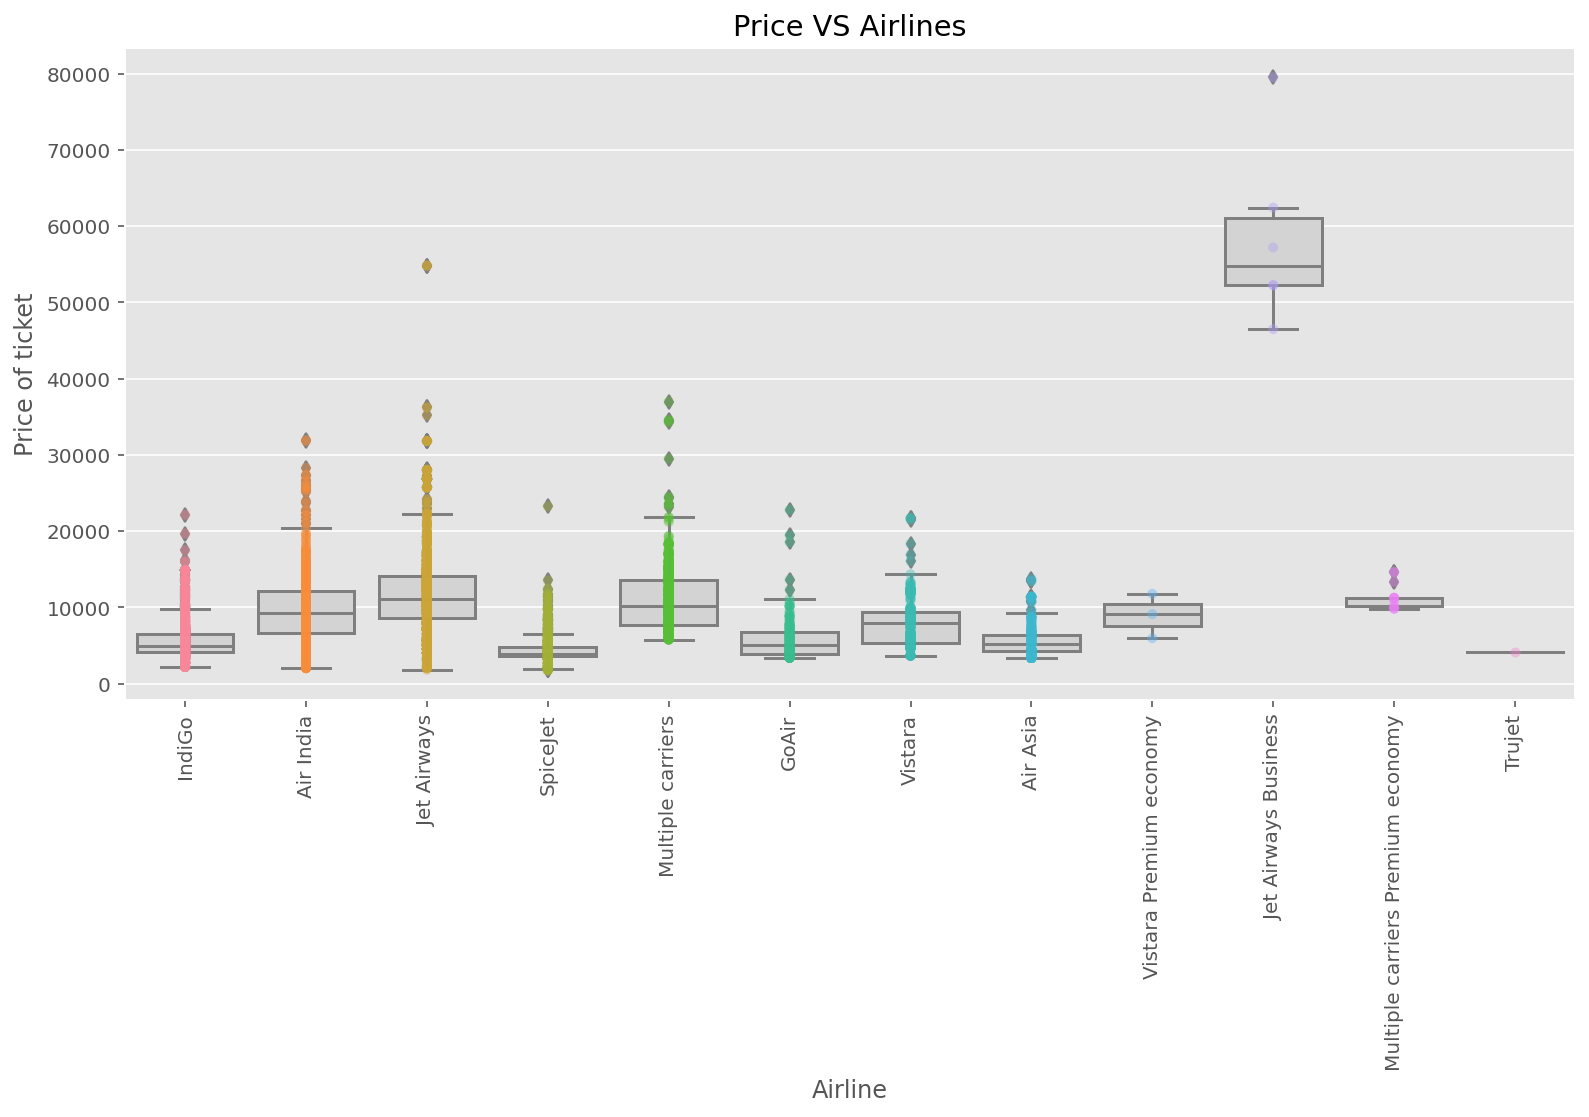

In [10]:
#| echo: false

# Comparing prices for each airline
plt.figure(figsize = (13,6))
sns.stripplot(data=df, x='airline', y='price', jitter=False, alpha=0.4)
sns.boxplot(df.airline, df.price, color='lightgray')
plt.title('Price VS Airlines')
plt.xticks
plt.xlabel('Airline')
plt.ylabel('Price of ticket')
plt.xticks(rotation = 90);

Insight: Jet Airways Business has the heighest median price.

### Machine Learning

#### Linear Regression

Model Steps:
* Create train/test split
* Create feature engineering transformers*
* Define a hyperparameter grid (when applicable)
* 5-fold cross validation, repeated 5 times
* Define a loss function, RMSE, Root Mean Squared Error
* Define an ML linear model*
* Tune the model hyperparameters

In [ ]:
#| echo: false
# load data
flights = pd.read_csv('../data/cleaned_data.csv')
# create train-test split
train, test = train_test_split(flights, test_size=0.3, random_state=123)

X_train = train.drop(columns='price')
y_train = train['price']

In [ ]:
#| echo: false
# Target Engineering
tt = TransformedTargetRegressor(transformer=PowerTransformer('box-cox'))

# Numeric feature engineering
nzv = VarianceThreshold(threshold=0.1)
yj = PowerTransformer(method='yeo-johnson')
scaler = StandardScaler()


### lump the infrequent categories
rare_encoder = RareLabelEncoder(tol=0.01, replace_with="other")
# rare_encoder.fit_transform(X_train)['airline'].unique()

# Categorical feature engineering
dummy_encoder = OneHotEncoder(drop='first')

# ordinal feature engineering
col = X_train['total_stops']
dict = {'0':0, '1':1, '2':2, '3':3, '4':4}
category_mapping = [{'col': 'total_stops', 'mapping': dict}]

ordinal_encoder = OrdinalEncoder(cols=['total_stops'], mapping=category_mapping)

In [ ]:
#| echo: false
# combine all steps into a preprocessing pipeline
def make_preprocessor(n=0, use_PCA=False):
    """creates a preprocesser which allows the user to specify whether to use PCA
    decomposition to reduce dimensionality of the data. 

    Args:
        n (int, optional): number of principal components in returned ColumnTransformer. Defaults to 0.
        use_PCA (bool, optional): set to True to get a preprocessor with PCA decomposition. Defaults to False.

    Returns:
        ColumnTransformer: sklearn object
    """
    if use_PCA:
        preprocessor = ColumnTransformer(
            remainder="passthrough",
            transformers=[
            # ("trans_target", tt, ),
            ("nzv_encode", nzv, selector(dtype_include="number")), #on/off
            ("yeo-johnson",yj, selector(dtype_include="number")),
            ("std_encode", scaler, selector(dtype_include="number")),
            ("PCA", PCA(n_components=n), selector(dtype_include="number")),
            # ('ordinal_encode', ordinal_encoder, ['total_stops']),  #on/off
            # ("rare_encode", rare_encoder, selector(dtype_include="object")),
            ("dummy_encode", dummy_encoder, selector(dtype_include="object")),
            ])
    else:
            preprocessor = ColumnTransformer(
            remainder="passthrough",
            transformers=[
            # ("trans_target", tt, ),
            ("nzv_encode", nzv, selector(dtype_include="number")), #on/off
            ("yeo-johnson",yj, selector(dtype_include="number")),
            ("std_encode", scaler, selector(dtype_include="number")),
            # ("PCA", PCA(n_components=n), selector(dtype_include="number")),
            # ('ordinal_encode', ordinal_encoder, ['total_stops']),  #on/off
            # ("rare_encode", rare_encoder, selector(dtype_include="object")),
            ("dummy_encode", dummy_encoder, selector(dtype_include="object")),
            ])
            
    return preprocessor

In [ ]:
#| echo: false
loss = 'neg_root_mean_squared_error'

cv = RepeatedKFold(n_splits=5, n_repeats=5)

#### Linear Model #1: Ordinary Least-squares Linear Regression

In [ ]:
#| echo: false
# Ordinary Least-squares Linear Regression Model with only dummy encoding

lm = LinearRegression()

preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ])

preprocessed_dummy_X_train = preprocessor_dummy.fit_transform(X_train)

results_lm = cross_val_score(lm, preprocessed_dummy_X_train, y_train, cv = cv, scoring=loss)

result = np.mean(np.abs(results_lm))
print(f"loss function: {loss}")
print(f"cross-validation folds: 5")
print(f"cross-validation repeats: 5")

print(f"mean score : {result}")

####Linear Model #2: Ordinary Least-squares Linear Regression. And numeric feature engineering

In [ ]:
#| echo: false
# Ordinary Least-squares Linear Regression Model with only dummy encoding and...
# Normalizing and standardizing and nzv_encode increases error!
# cost = ~3000

lm = LinearRegression()

preprocessor = ColumnTransformer(
remainder="passthrough",
transformers=[

("nzv_encode", nzv, selector(dtype_include="number")), 
("yeo-johnson",yj, selector(dtype_include="number")),
("std_encode", scaler, selector(dtype_include="number")),
("dummy_encode", dummy_encoder, selector(dtype_include="object")),
])

preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ])

preprocessed_dummy_X_train = preprocessor_dummy.fit_transform(X_train)

results_lm = cross_val_score(lm, preprocessed_dummy_X_train, y_train, cv = cv, scoring=loss)

result = np.mean(np.abs(results_lm))
print(f"feature engineering: dummy encoding and near-zero variance exclusion, normalization, and standarization") 
print(f"mean score : {result}")

#### Linear Model #3: Principal Component Analysis (PCA)

In [ ]:
#| echo: false
# PCA Model. cost = ~2500

preprocessed_X_train_PCA_4 = make_preprocessor(4, True).fit_transform(X_train)
preprocessed_X_train_PCA_3 = make_preprocessor(3, True).fit_transform(X_train)
preprocessed_X_train_PCA_2 = make_preprocessor(2, True).fit_transform(X_train)
preprocessed_X_train_PCA_1 = make_preprocessor(1, True).fit_transform(X_train)

results_PCA_4 = cross_val_score(lm, preprocessed_X_train_PCA_4, y_train, cv = cv, scoring=loss)
results_PCA_3 = cross_val_score(lm, preprocessed_X_train_PCA_3, y_train, cv = cv, scoring=loss)
results_PCA_2 = cross_val_score(lm, preprocessed_X_train_PCA_2, y_train, cv = cv, scoring=loss)
results_PCA_1 = cross_val_score(lm, preprocessed_X_train_PCA_1, y_train, cv = cv, scoring=loss)

result_PCA4 = np.mean(np.abs(results_PCA_4))
result_PCA3 = np.mean(np.abs(results_PCA_3))
result_PCA2 = np.mean(np.abs(results_PCA_2))
result_PCA1 = np.mean(np.abs(results_PCA_1))

print(f"feature engineering: dummy encoding and near-zero variance exclusion, normalization, and standarization") 
print(f"mean score for linear model with 4 principle components: {result_PCA4}")
print(f"mean score for linear model with 3 principle components: {result_PCA3}")
print(f"mean score for linear model with 2 principle components: {result_PCA2}")
print(f"mean score for linear model with 1 principle components: {result_PCA1}")

#### Linear Model #4: Partial Least Squares

In [ ]:
#| echo: false
# Partial Least Squares Linear Model with only dummy_encode

preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("dummy_encode", OneHotEncoder(drop='first', sparse=False), selector(dtype_include="object"))
  ])

preprocessed_dummy_X_train = preprocessor_dummy.fit_transform(X_train)


pls_mod = cross_decomposition.PLSRegression()

hyper_grid = {'n_components': range(2, 28, 2)}


grid_search = GridSearchCV(
  pls_mod, 
  hyper_grid, 
  cv=cv, 
  scoring=loss
  )
  

results_PLS = grid_search.fit(preprocessed_dummy_X_train, y_train)

result = abs(results_PLS.best_score_)
print(f"feature engineering: dummy encoding") 
print(f"best score: {result}")
print(f"optimal number of components: {results_PLS.best_estimator_}")

More feature engineering with partial leaset squares...

In [ ]:
#| echo: false
# Partial Least Squares Linear Model with dummy_encode
# Normalizing and standardizing and nzv_encode make no difference!
# cost = ~2500

preprocessor_all = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("nzv_encode", nzv, selector(dtype_include="number")), 
      ("yeo-johnson",yj, selector(dtype_include="number")),
      ("std_encode", scaler, selector(dtype_include="number")),
      ("dummy_encode", OneHotEncoder(drop='first', sparse=False), selector(dtype_include="object"))
  ])

preprocessed_dummy_X_train = preprocessor_all.fit_transform(X_train)


pls_mod = cross_decomposition.PLSRegression()

hyper_grid = {'n_components': range(2, 28, 2)}


grid_search = GridSearchCV(
  pls_mod, 
  hyper_grid, 
  cv=cv, 
  scoring=loss
  )
  

results_PLS = grid_search.fit(preprocessed_dummy_X_train, y_train)

result = abs(results_PLS.best_score_)
print(f"feature engineering: dummy encoding and near-zero variance exclusion, normalization, and standarization") 
print(f"best score: {result}")
print(f"optimal number of components: {results_PLS.best_estimator_}")

#### Linear Model #5.1: Regularized Linear Regression: Lasso (L1-Norm)

In [ ]:
#| echo: false
# Regularized Linear Regression with Lasso and only dummy encoding
# Normalizing and standardizing and nzv_encode make no difference!
# cost = ~2500

preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("nzv_encode", nzv, selector(dtype_include="number")), 
      ("yeo-johnson",yj, selector(dtype_include="number")),
      ("std_encode", scaler, selector(dtype_include="number")),
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ])

preprocessed_dummy_X_train = preprocessor_dummy.fit_transform(X_train)

# create model object
mod = Lasso()

# Create grid of hyperparameter values
hyper_grid = {
  'alpha': 10**np.linspace(10, -5, 10)*0.5,
  }

# 5-fold CV grid search
grid_search = GridSearchCV(mod, hyper_grid, cv=cv, scoring=loss)
results_Lasso = grid_search.fit(preprocessed_dummy_X_train, y_train)

# Optimal penalty parameter in grid search
result = np.abs(results_Lasso.best_score_)
print(f"feature engineering: dummy encoding and near-zero variance exclusion, normalization, and standarization") 
print(f"best score: {result}")
print(f"alpha: {results_Lasso.best_estimator_}")

#### Linear Model #5.2: Regularized Linear Regression: Ridge (L2-Norm)

In [ ]:
#| echo: false
# Regularized Linear Regression with Lasso and only dummy encoding
# Normalizing and standardizing and nzv_encode make no difference!
# cost = ~4000

preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("nzv_encode", nzv, selector(dtype_include="number")), 
      ("yeo-johnson",yj, selector(dtype_include="number")),
      ("std_encode", scaler, selector(dtype_include="number")),
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ])

preprocessed_X_train = preprocessor_dummy.fit_transform(X_train)


# create model object
mod = Ridge()

# Create grid of hyperparameter values
hyper_grid = {
  'alpha': 10**np.linspace(10, -5, 10)*0.5,
  # 'l1_ratio': (0, 0.25, 0.5, 0.75 , 1)
  }

# 5-fold CV grid search
grid_search = GridSearchCV(mod, hyper_grid, cv=cv, scoring=loss)
results_Ridge = grid_search.fit(preprocessed_dummy_X_train, y_train)

# Optimal penalty parameter in grid search
result = np.abs(results_Ridge.best_score_)
print(f"feature engineering: dummy encoding and near-zero variance exclusion, normalization, and standarization") 
print(f"best score: {result}")
print(f"alpha: {results_Ridge.best_estimator_}")


In [ ]:
#| echo: false
# Regularized Linear Regression with elastic net and dummy encoding
# Normalizing and standardizing and nzv_encode make no difference!
# cost = ~2400



preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("nzv_encode", nzv, selector(dtype_include="number")), 
      ("yeo-johnson",yj, selector(dtype_include="number")),
      ("std_encode", scaler, selector(dtype_include="number")),
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ])

preprocessed_X_train = preprocessor_dummy.fit_transform(X_train)




# create model object
mod = ElasticNet(tol=0.01)

# Create grid of hyperparameter values
hyper_grid = {
  'alpha': 10**np.linspace(10, -5, 10)*0.5,
  'l1_ratio': (0, 0.25, 0.5, 0.75 , 1)
  }

# 5-fold CV grid search
grid_search = GridSearchCV(mod, hyper_grid, cv=cv, scoring=loss)
results_elastic_41 = grid_search.fit(preprocessed_X_train, y_train)

# Optimal penalty parameter in grid search
result = np.abs(results_elastic.best_score_)
print(f"feature engineering: dummy encoding and near-zero variance exclusion, normalization, and standarization") 
print(f"best score: {result}")
print(f"alpha: {results_elastic.best_estimator_}")



No more linear models to try... 

### Feature Importance

In [ ]:
#| echo: false
# Feature Importance

# get feature names
feat_names = ColumnTransformer(
  remainder="passthrough",
  transformers=[
    
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ]).fit(X_train).get_feature_names_out()

# create DataFrame with feature name and coefficients from best model
coef_df = pd.DataFrame({'feature': feat_names,
                     'coef': results_elastic.best_estimator_.coef_})

# filter for the top 25
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df['impact'] = np.where(coef_df['coef']>0, 'positive', 'negative')

top_25_features = coef_df.nlargest(25, 'abs_coef')
top_25_features.head()


#%%
(ggplot(top_25_features, aes(x='abs_coef', y='reorder(feature, abs_coef)', color='impact', fill='impact'))
 + geom_point()
 + labs(y=None)
 + labs(title="Feature Importance Analysis"))

In [ ]:
#| echo: false
# get feature names
feat_names_41 = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("nzv_encode", nzv, selector(dtype_include="number")), 
      ("yeo-johnson",yj, selector(dtype_include="number")),
      ("std_encode", scaler, selector(dtype_include="number")),
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ]).fit(X_train).get_feature_names_out()

# create DataFrame with feature name and coefficients from best model
#results_elastic_orig = results_elastic
coef_df_41 = pd.DataFrame({'feature': feat_names_41,
                     'coef': results_elastic_41.best_estimator_.coef_})

coef_df_41['abs_coef'] = coef_df_41['coef'].abs()
coef_df_41['impact'] = np.where(coef_df_41['coef']>0, 'positive', 'negative')

In [ ]:
#| echo: false
preprocessor_dummy = ColumnTransformer(
  remainder="passthrough",
  transformers=[
      ("nzv_encode", nzv, selector(dtype_include="number")), 
      ("yeo-johnson",yj, selector(dtype_include="number")),
      ("std_encode", scaler, selector(dtype_include="number")),
      ("dummy_encode", OneHotEncoder(drop='first'), selector(dtype_include="object"))
  ])

preprocessed_X_train = preprocessor_dummy.fit_transform(X_train)

### Complexity V.S. Interpretability 

Reducing the number of features in a model boosts interpretability. How much predictive power can be maintained when reducing 5, 10, 15, etc., features from our model?

In [ ]:
#| echo: false
number_features = []
scores = []
alphas = []
l1_ratios = []


for n in range(40, 0, -5):
    most_important_features = list(coef_df_41.sort_values(by=["abs_coef"], axis=0, ascending=False).reset_index().iloc[0:n,1])
    # print(type(most_important_features))
    # print(most_important_features)
    X_train_reduced_df = pd.DataFrame(preprocessed_X_train, columns=feat_names_41)
    # print(X_train_reduced_df.columns)
    # print(most_important_features)
    X_train_reduced = X_train_reduced_df[most_important_features]
    

    # create model object
    mod = ElasticNet(tol=0.01)

    # Create grid of hyperparameter values
    hyper_grid = {
      'alpha': 10**np.linspace(10, -5, 10)*0.5,
      'l1_ratio': (0.25, 0.5, 0.75 , 1)
      }

    # 5-fold CV grid search
    grid_search = GridSearchCV(mod, hyper_grid, cv=cv, scoring=loss)
    results_elastic_reduced = grid_search.fit(X_train_reduced, y_train)
    
    

    # Optimal penalty parameter in grid search
    result = np.abs(results_elastic_reduced.best_score_)
    alpha = results_elastic_reduced.best_params_['alpha']
    l1_ratio = results_elastic_reduced.best_params_['l1_ratio']
    num_feat = X_train_reduced.shape[1]
    
    number_features.append(num_feat)
    scores.append(result)
    alphas.append(alpha)
    l1_ratios.append(l1_ratio)
    
    
    
    print(f"The number of features: {num_feat}")
    print(f"Best score: {result}")
    print(f"alpha: {alpha}")
    print(f"L1 Ratio: {l1_ratio}", end="\n\n")

In [ ]:
#| echo: false
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(scoring_df.num_features,
        scoring_df.rmse,
        color="red", 
        marker="o")
# set x-axis label
ax.set_xlabel("The number of features", fontsize = 14)
# set y-axis label
ax.set_ylabel("RMSE",
              color="red",
              fontsize=14)
ax.set_title("Relationship Between Number of Features (complexity) and Performance (RMSE)")

ax.set_title("Cost as function of number of features")

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(scoring_df.num_features, scoring_df.alpha,color="blue",marker="o")
ax2.set_ylabel("alpha",color="blue",fontsize=14)

plt.gca().invert_xaxis()

plt.show()

#### KNN
Model Steps:
- Create train/test split
- Separate features from labels and only use numeric features
- Features engineering  
- Create grid of hyperparameter values
- 10 fold CV object
- Defind a loss function (RMSE)
- KNN model object
- Tune the model using grid search

In [12]:
#| echo: false

# Split the data into train and test splits.
train, test = train_test_split(df, train_size=0.8, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)
y_test = test['price']

In [13]:
#| echo: false

# create KNN model object
knn = KNeighborsRegressor()

# define loss function
loss = 'neg_root_mean_squared_error'

# create 10 fold CV object
kfold = KFold(n_splits=10)#, random_state=123, shuffle=True)

# Create grid of hyperparameter values
hyper_grid = {'knn__n_neighbors': range(2, 26)}

# Center and scale (i.e., standardize) all numeric features
scaler = StandardScaler()

# One-hot encode remaining categorical features.
encoder = OneHotEncoder(handle_unknown="ignore")

# combine all steps into a preprocessing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
  ("std_encode", scaler, selector(dtype_include="number")),
  ("one-hot", encoder, selector(dtype_include="object"))
  ])

model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("knn", knn),
])

# Tune a knn model using grid search
grid_search = GridSearchCV(model_pipeline, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train, y_train)

# Best model's k value
print('Optimal hyperparameter')
print(f'Best K value: {results.best_estimator_.get_params().get("knn__n_neighbors")}')

# Best model's cross validated RMSE
print(f'Best KNN RMSE: {abs(results.best_score_)}', end='\n\n')


Optimal hyperparameter
Best K value: 3
Best KNN RMSE: 2142.801354153572



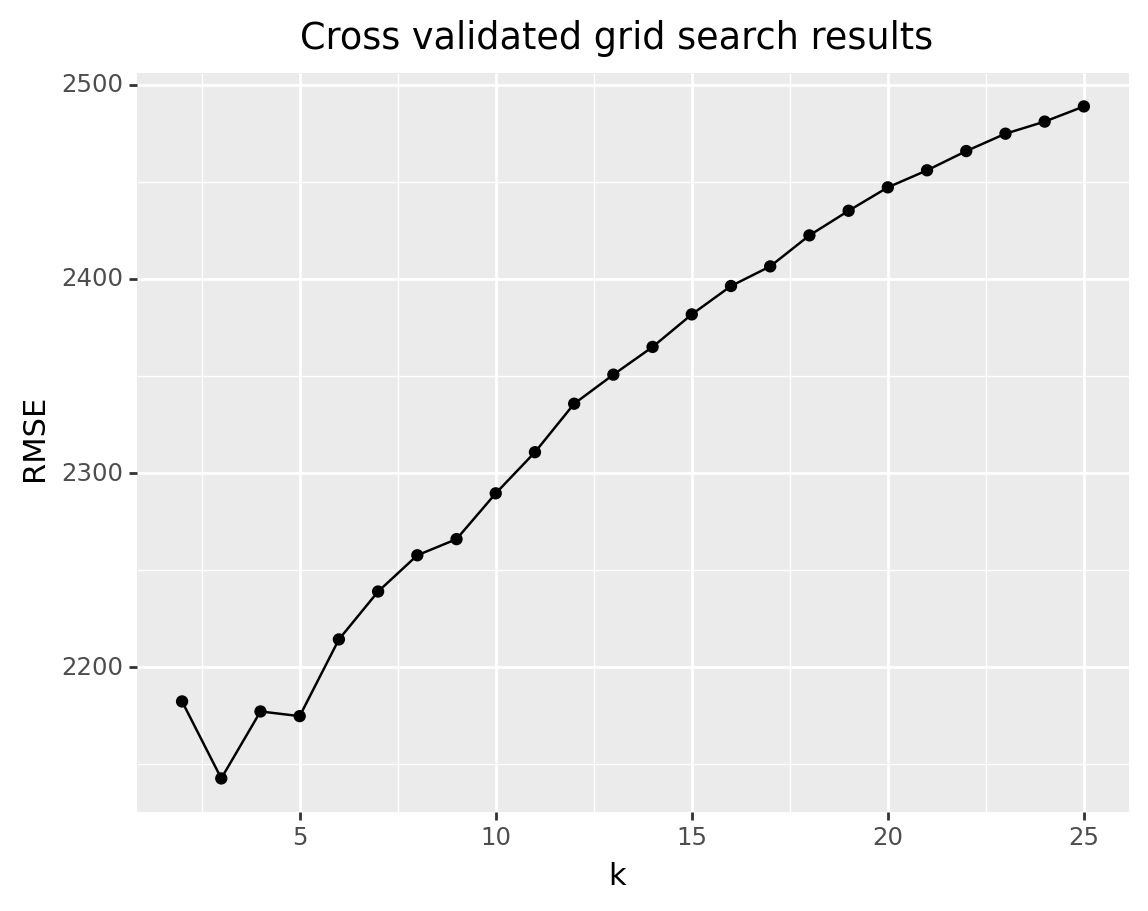

<ggplot: (167767117590)>

In [14]:
#| echo: false

# Plot all RMSE results
all_rmse = pd.DataFrame({'k': range(2, 26), 
                         'RMSE': np.abs(results.cv_results_['mean_test_score'])})

(ggplot(all_rmse, aes(x='k', y='RMSE'))
 + geom_line()
 + geom_point()
 + ggtitle("Cross validated grid search results"))

#### Decision Tree
Model Steps:
- Create train/test split
- Separate features from labels and only use numeric features
- Features engineering  
- Create grid of hyperparameter values
- 10 fold CV object
- Defind a loss function (RMSE)
- Decision tree model object
- Tune the model using grid search

In [15]:
#| echo: false

# create train/test split
train, test = train_test_split(df, train_size=0.8, random_state=123)

# separate features from labels and only use numeric features
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

#Decision Tress model object
dt_mod = DecisionTreeRegressor()

#loss function
loss = 'neg_root_mean_squared_error'

# 10 fold CV object
kfold = KFold(n_splits=10) #random_state=123, shuffle=True)

# create new feature set with encoded features
X_train_encoded = pd.get_dummies(X_train)

# Create grid of hyperparameter values
hyper_grid = {
  'ccp_alpha': [1e-1, 1e-5, 1e-10],
  'max_depth': [1, 8, 15],
  'min_samples_split': [2, 21, 40]
  }

#Tune the model using grid search
grid_search = GridSearchCV(dt_mod, hyper_grid, cv=kfold, scoring=loss)
results = grid_search.fit(X_train_encoded, y_train)


# Optimal penalty parameter in grid search
print('Optimal hyperparameter')
print("ccp_alpha: ", results.best_estimator_.get_params().get('ccp_alpha'))
print("max_depth: ", results.best_estimator_.get_params().get('max_depth'))
print("min_samples_split: ", results.best_estimator_.get_params().get('min_samples_split'), end="\n\n")

# Best model's cross validated RMSE
print("Best Decision Tree cross validated RMSE: ", round(abs(results.best_score_), 2))

Optimal hyperparameter
ccp_alpha:  1e-10
max_depth:  15
min_samples_split:  21

Best Decision Tree cross validated RMSE:  1869.27


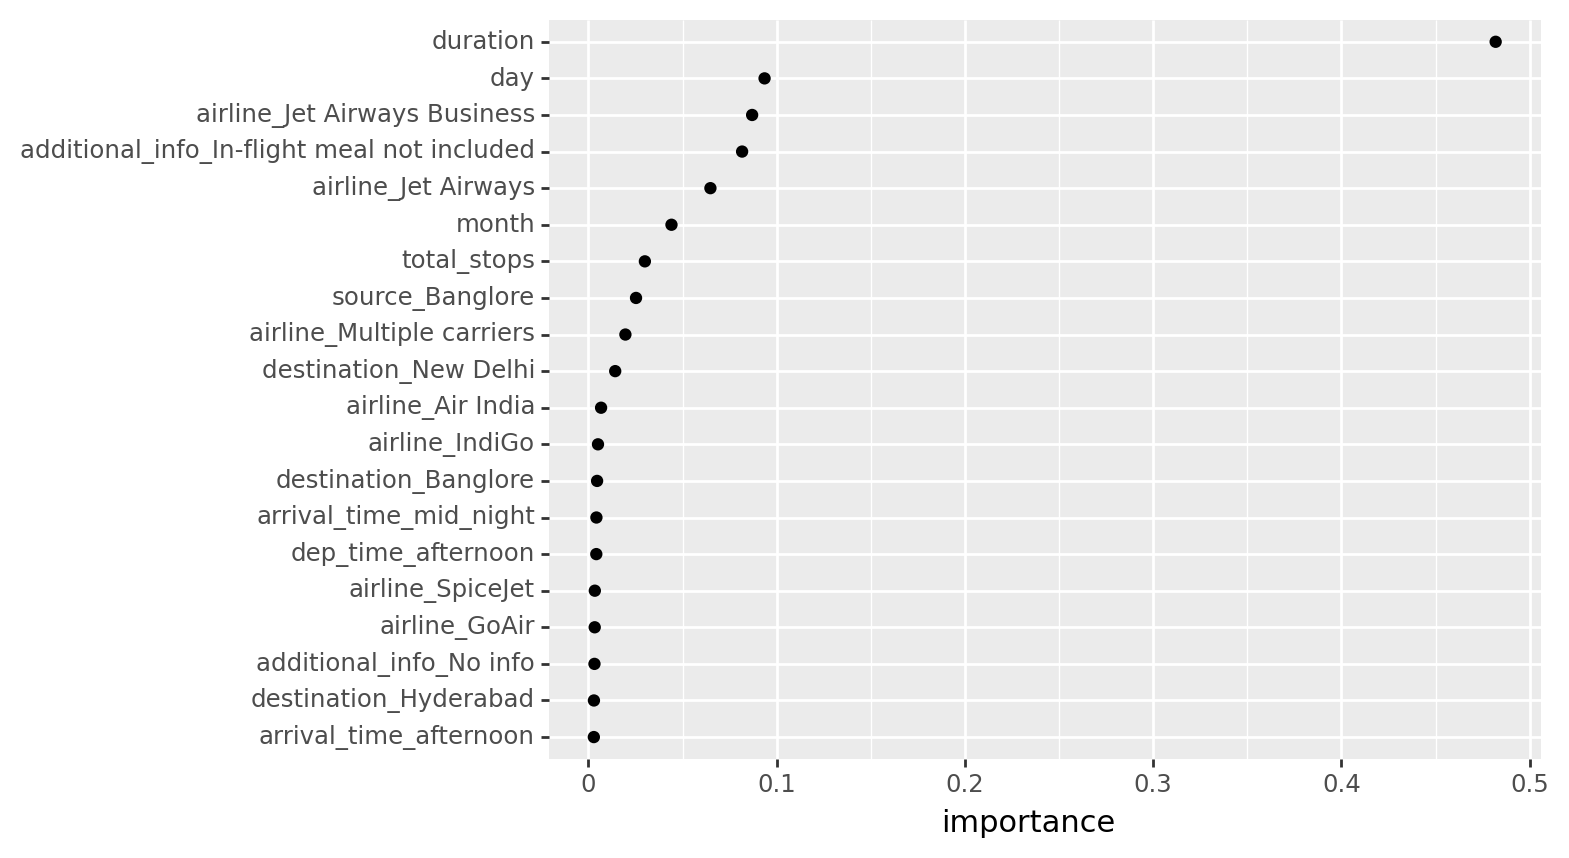

<ggplot: (167766389640)>

In [16]:
#| echo: false

# create final model object
best_mod = results.best_estimator_
best_mod_fit = best_mod.fit(X_train_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': X_train_encoded.columns,
                   'importance': best_mod_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

Duration has is the important feature

#### Gradient Boosting

In [17]:
#| echo: false

# One hot encode remaining nominal features
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Combine into a pre-processing pipeline
preprocessor = ColumnTransformer(
  remainder="passthrough",
  transformers=[
   ("one-hot", encoder, selector(dtype_include="object")),
   ]
  )

In [18]:
#| echo: false

# GBM Estimator Model Object
xgb_mod = xgb.XGBRegressor()

#Loss Function
loss = 'neg_root_mean_squared_error'

#Creating a pipeline
model_pipeline = Pipeline(steps=[
  ("preprocessor", preprocessor),
  ("xgb_mod", xgb_mod),
])


kfold = KFold(n_splits=5, random_state=123, shuffle=True)

# Setting the Hyperparameters
hyper_grid = {
  'xgb_mod__n_estimators': [1000, 2500, 5000],
  'xgb_mod__learning_rate': [0.001, 0.01, 0.1],
  'xgb_mod__max_depth': [3, 5, 7, 9],
  'xgb_mod__min_child_weight': [1, 5, 15] 
}

# Implementing a five fold CV
results = cross_val_score(model_pipeline, X_train, y_train, cv=kfold, scoring=loss)

print('Gradient Boosting RMSE: ', np.abs(np.mean(results)), end='\n\n')


# create random search object
random_search = RandomizedSearchCV(
    model_pipeline, 
    param_distributions=hyper_grid, 
    n_iter=20, 
    cv=kfold, 
    scoring=loss, 
    n_jobs=-1, 
    random_state=13
)

# Execute random search
random_search_results = random_search.fit(X_train, y_train)

# Best model score
print('Gradient Boosting random search RMSE: ', np.abs(random_search_results.best_score_), end='\n\n')

# Optimal penalty parameter in grid search
print('Optimal hyperparameter')
print("xgb_mod__n_estimators: ", random_search_results.best_estimator_.get_params().get('xgb_mod__n_estimators'))
print("xgb_mod__learning_rate: ", random_search_results.best_estimator_.get_params().get('xgb_mod__learning_rate'))
print("xgb_mod__max_depth: ", random_search_results.best_estimator_.get_params().get('xgb_mod__max_depth'))
print("xgb_mod__min_child_weight: ", random_search_results.best_estimator_.get_params().get('xgb_mod__min_child_weight'), end="\n\n")

Gradient Boosting RMSE:  1669.3974306455425



Gradient Boosting random search RMSE:  1614.05097475437

Optimal hyperparameter
xgb_mod__n_estimators:  2500
xgb_mod__learning_rate:  0.01
xgb_mod__max_depth:  9
xgb_mod__min_child_weight:  1



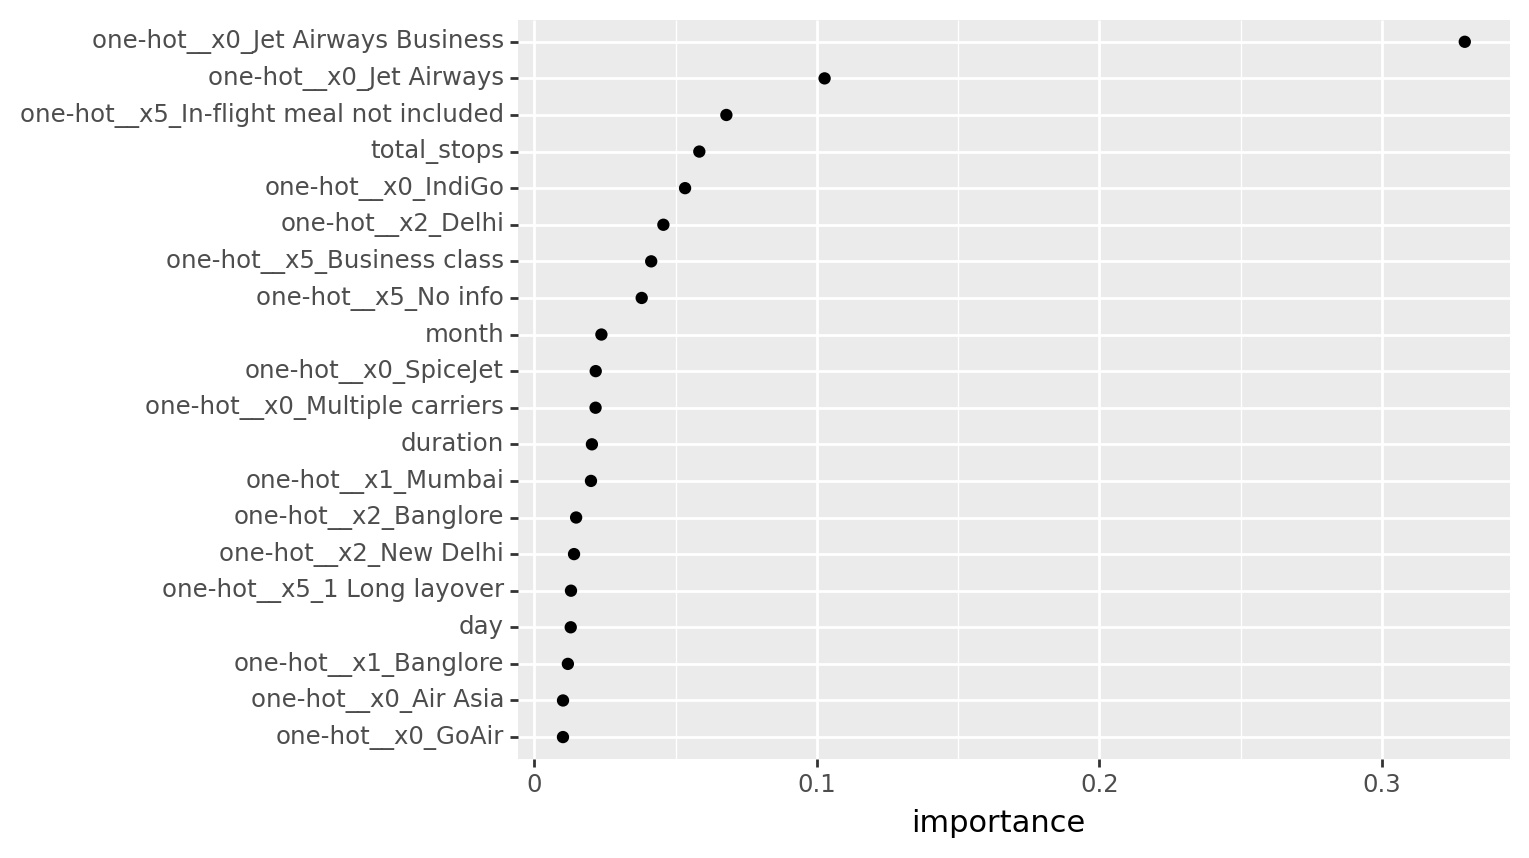

<ggplot: (167637996207)>

In [19]:
#| echo: false

#This is to separate the features or attribute from the target
X_train = train.drop("price", axis=1)
y_train = train[["price"]]

# preprocess training data
X_encoded = preprocessor.fit_transform(X_train)

# create final model object
final_model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=0.75,
    colsample_bylevel=0.75,
    colsample_bynode=0.75
)

final_model_fit = final_model.fit(X_encoded, y_train)

# extract feature importances
vi = pd.DataFrame({'feature': preprocessor.get_feature_names(),
                   'importance': final_model_fit.feature_importances_})

# get top 20 influential features
top_20_features = vi.nlargest(20, 'importance')

# plot feature importance
(ggplot(top_20_features, aes(x='importance', y='reorder(feature, importance)'))
 + geom_point()
 + labs(y=None))

#### Deep Learning